[*********************100%***********************]  1 of 1 completed


Epoch 0 | MSE: 0.027585
Epoch 1 | MSE: 0.001277
Epoch 2 | MSE: 0.000804
Epoch 3 | MSE: 0.000611
Epoch 4 | MSE: 0.000543
Epoch 5 | MSE: 0.000505
Epoch 6 | MSE: 0.000567
Epoch 7 | MSE: 0.000494
Epoch 8 | MSE: 0.000551
Epoch 9 | MSE: 0.000451
Epoch 10 | MSE: 0.000432
Epoch 11 | MSE: 0.000441
Epoch 12 | MSE: 0.000426
Epoch 13 | MSE: 0.000387
Epoch 14 | MSE: 0.000374
Epoch 15 | MSE: 0.000388
Epoch 16 | MSE: 0.000390
Epoch 17 | MSE: 0.000340
Epoch 18 | MSE: 0.000355
Epoch 19 | MSE: 0.000381

LSTM t+1 RMSE: 93.17507047219262
LSTM t+1 MAE : 76.13423047434635

SARIMA RMSE: 961.2020148744957
SARIMA MAE : 892.7866085929627


  0%|          | 0/20 [00:00<?, ?it/s]

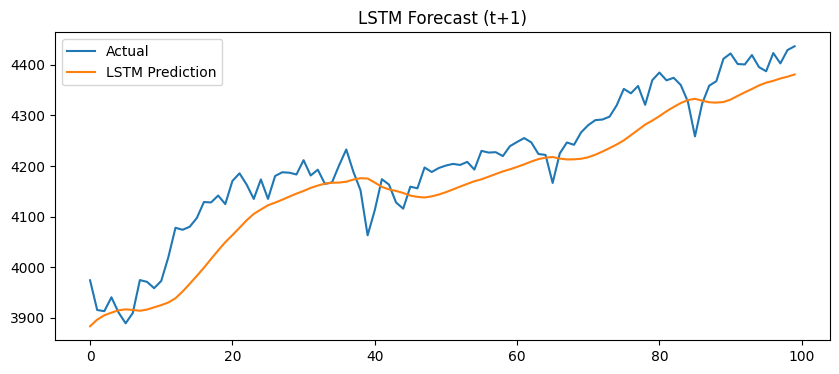

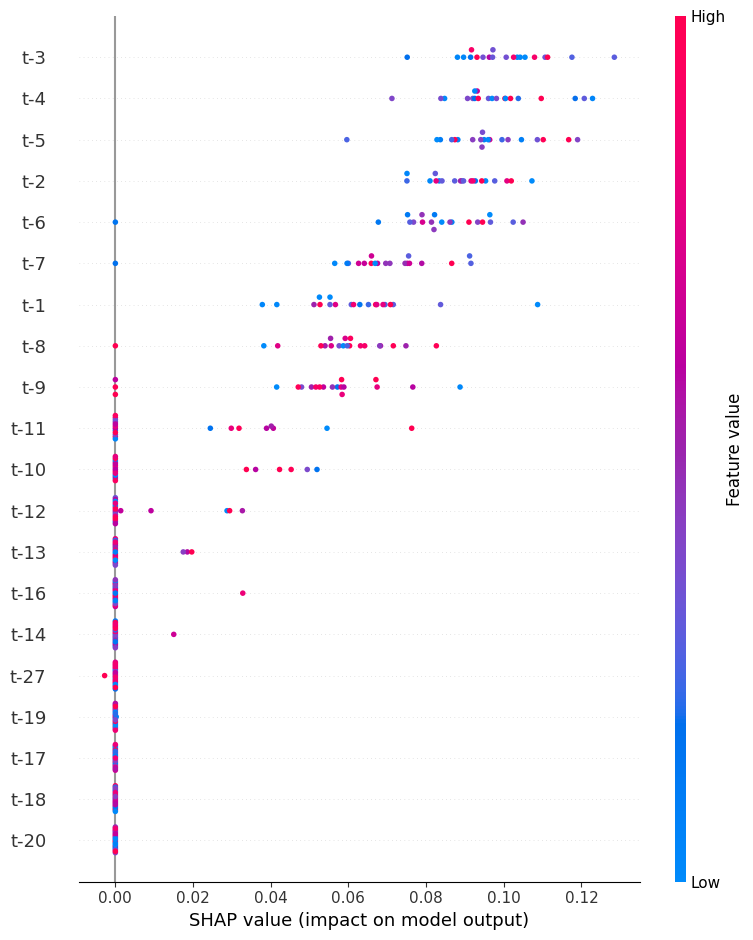


FINAL MODEL
LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)


In [3]:
# ======================================================
# FINAL CORRECT VERSION (ERROR-FREE)
# LSTM + SARIMA + SHAP (t+1 EXPLAINABILITY)
# ======================================================

import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

# =======================
# 1. DATA
# =======================
df = yf.download("^GSPC", start="2010-01-01", end="2024-01-01")
data = df[["Close"]].dropna()

# =======================
# 2. PREPROCESSING
# =======================
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data)

SEQ_LEN = 30
HORIZON = 5

def create_sequences(series):
    X, y = [], []
    for i in range(len(series) - SEQ_LEN - HORIZON):
        X.append(series[i:i+SEQ_LEN])
        y.append(series[i+SEQ_LEN:i+SEQ_LEN+HORIZON])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

train_loader = DataLoader(
    TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                  torch.tensor(y_train, dtype=torch.float32)),
    batch_size=32, shuffle=True
)

# =======================
# 3. LSTM MODEL
# =======================
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, 2, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(64, HORIZON)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

model = LSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# =======================
# 4. TRAINING
# =======================
for epoch in range(20):
    model.train()
    loss_sum = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb.squeeze(-1))
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    print(f"Epoch {epoch} | MSE: {loss_sum/len(train_loader):.6f}")

# =======================
# 5. EVALUATION
# =======================
model.eval()
with torch.no_grad():
    preds = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

preds_inv = scaler.inverse_transform(preds.reshape(-1,1)).reshape(preds.shape)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).reshape(y_test.shape)

rmse = np.sqrt(mean_squared_error(y_test_inv[:,0], preds_inv[:,0]))
mae = mean_absolute_error(y_test_inv[:,0], preds_inv[:,0])

print("\nLSTM t+1 RMSE:", rmse)
print("LSTM t+1 MAE :", mae)

# =======================
# 6. SARIMA BASELINE
# =======================
sarima = SARIMAX(data, order=(1,1,1), seasonal_order=(1,1,1,12)).fit(disp=False)
sarima_preds = sarima.forecast(steps=len(y_test_inv))

rmse_s = np.sqrt(mean_squared_error(y_test_inv[:,0], sarima_preds))
mae_s = mean_absolute_error(y_test_inv[:,0], sarima_preds)

print("\nSARIMA RMSE:", rmse_s)
print("SARIMA MAE :", mae_s)

# =======================
# 7. SHAP (CORRECT & STABLE)
# =======================
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

def shap_predict(x_flat):
    x = x_flat.reshape(-1, SEQ_LEN, 1)
    with torch.no_grad():
        return model(torch.tensor(x, dtype=torch.float32)).numpy()[:, 0]  # t+1 only

explainer = shap.KernelExplainer(shap_predict, X_train_flat[:100])
shap_values = explainer.shap_values(X_test_flat[:20], nsamples=100)

# =======================
# 8. VISUALIZATION
# =======================
plt.figure(figsize=(10,4))
plt.plot(y_test_inv[:100,0], label="Actual")
plt.plot(preds_inv[:100,0], label="LSTM Prediction")
plt.title("LSTM Forecast (t+1)")
plt.legend()
plt.show()

shap.summary_plot(
    shap_values,
    X_test_flat[:20],
    feature_names=[f"t-{i}" for i in range(SEQ_LEN,0,-1)]
)

# =======================
# 9. MODEL SUMMARY
# =======================
print("\nFINAL MODEL")
print(model)
